# **LSTM VAE**
This notebook trains an LSTM-based variational autoencoder (VAE) on sequences of six-channel pose trajectories (XYZ + α/β/γ) sampled at 50 Hz. Each CSV file captures one motion, and the model learns to encode, reconstruct, and synthesise new trajectories.

*Notes:*

*updated normalization to sin/cos to avoid the wrap-around at ±π*

*if trajectories jump across that boundary, differences like -3.13 vs +3.13 become large after z-scoring even though the physical rotation changed little.*


## **0 Params**

In [2]:
# import
import re
import math
import random
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.lines import Line2D
plt.rcParams['font.family'] = 'monospace'

try:
    from openTSNE import TSNE
except ImportError as exc:
    raise ImportError("openTSNE is required for latent-space plots. Install it via `pip install openTSNE`.") from exc

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F


# Fix random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Pick GPU when available; fall back to CPU otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Hyperparameters
batch_size = 16
latent_dim = 32
hidden_dim = 128
num_layers = 2
learning_rate = 1e-3
beta = 1e-3
max_grad_norm = 2.0
huber_beta = 0.001  # SmoothL1 transition point for reconstruction loss. adjust for sharper/smoother transition
num_epochs = 200

# Set to False to skip training for speed run
run_training = False 

In [4]:
# higher-res figure display setting for matplotlib

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300  

## **1. Data Loading**

*loads csvs, wraps into dataset loader with normalization & padding for consistent seq length*

In [5]:
# Discover motion CSVs and measure sequence length statistics
data_dir = Path("data/cleaned_z240")
seq_columns = ["X_mm", "Y_mm", "Z_mm", "alpha_rad", "beta_rad", "gamma_rad"]

# Enumerate trajectory files and ensure the folder is populated
csv_files = sorted(data_dir.glob("*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found under {data_dir.resolve()}")

# Track min/mean/max sequence lengths for padding decisions
lengths = [len(pd.read_csv(fp)) for fp in csv_files]
max_seq_len = max(lengths)
min_seq_len = min(lengths)
mean_seq_len = float(np.mean(lengths))

# Track max/min z-values to confirm cleaning
z_values = []
for fp in csv_files:
    df = pd.read_csv(fp)
    z_values.extend(df["Z_mm"].values)
z_min = min(z_values)
z_max = max(z_values)

print(f"Found {len(csv_files)} motion files")
print(f"Sequence length stats -> min: {min_seq_len}, max: {max_seq_len}, mean: {mean_seq_len:.1f} timesteps")
print(f"Z range across all files: min {z_min}, max {z_max}")


Found 300 motion files
Sequence length stats -> min: 19, max: 233, mean: 81.0 timesteps
Z range across all files: min -32.8416575184545, max 54.32344946301774


In [6]:
# Dataset wrapper that takes in the dataset, normalises and pads robot joint trajectories
# Each tejectory will be converted to a tensor
class MotionSequenceDataset(Dataset):
    def __init__(self, files, columns, max_seq_len, stats=None):
        
        # Cache file paths and the joint columns to load
        self.files = [Path(f) for f in files]
        self.columns = list(columns)
        self.max_seq_len = max_seq_len

        # Split the feature set into positional values and angular coordinates (in radians)
        self.angle_columns = [col for col in self.columns if col.endswith("_rad")]
        self.non_angle_columns = [col for col in self.columns if col not in self.angle_columns]
        self.angle_indices = [self.columns.index(col) for col in self.angle_columns]
        self.non_angle_indices = [self.columns.index(col) for col in self.non_angle_columns]
        self.angle_count = len(self.angle_columns)
        self.non_angle_count = len(self.non_angle_columns)

        # Keep track of the encoded feature ordering for downstream use (e.g. weighting)
        self.feature_names = list(self.non_angle_columns)
        if self.angle_count:
            self.feature_names += [f"sin_{col}" for col in self.angle_columns]
            self.feature_names += [f"cos_{col}" for col in self.angle_columns]

        raw_sequences = []
        lengths = []
        for path in self.files:
            # Load individual trajectory and convert to tensor
            df = pd.read_csv(path)
            seq = torch.tensor(df[self.columns].values, dtype=torch.float32)
            seq = self._encode_angles(seq)
            raw_sequences.append(seq)
            lengths.append(seq.shape[0])

        clipped = []
        effective_lengths = []
        for seq in raw_sequences:
            # Clip to maximum sequence length expected by the model
            # if too long, clip else keep original
            if seq.shape[0] > self.max_seq_len:
                clipped.append(seq[: self.max_seq_len])
                effective_lengths.append(self.max_seq_len)
            else:
                clipped.append(seq)
                effective_lengths.append(seq.shape[0])

        self.lengths = effective_lengths
        self.lengths_tensor = torch.tensor(self.lengths, dtype=torch.long)

        if stats is None:
            # Compute dataset-wide normalisation stats from training data
            stacked = torch.cat(clipped, dim=0)
            mean = stacked.mean(dim=0)
            std = stacked.std(dim=0).clamp_min(1e-6)
            self.stats = (mean, std)
        else:
            # Reuse provided mean/std for validation/test splits
            mean, std = stats
            self.stats = (mean.clone(), std.clone())

        mean, std = self.stats
        normalized = []
        for seq, length in zip(clipped, self.lengths):
            # Zero-pad shorter sequences then normalise with shared stats
            padded = torch.zeros(self.max_seq_len, seq.shape[1], dtype=torch.float32)
            padded[:length] = seq
            normalized.append((padded - mean) / std)

        self.data = torch.stack(normalized)
        self.feature_dim = self.data.shape[-1]

    def _encode_angles(self, seq):
        if self.angle_count == 0:
            return seq
        non_angle = seq[:, self.non_angle_indices]
        angles = seq[:, self.angle_indices]
        sin = torch.sin(angles)
        cos = torch.cos(angles)
        return torch.cat([non_angle, sin, cos], dim=1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Return the padded sequence and its true (unpadded) length
        return self.data[idx], torch.tensor(self.lengths[idx], dtype=torch.long)

    def denormalize(self, tensor):
        # Restore sequences back to the original physical units
        mean, std = self.stats
        mean = mean.to(tensor.device)
        std = std.to(tensor.device)
        processed = tensor * std + mean

        if self.angle_count == 0:
            return processed

        non_angle = processed[..., :self.non_angle_count]
        sin = processed[..., self.non_angle_count:self.non_angle_count + self.angle_count]
        cos = processed[..., self.non_angle_count + self.angle_count:]
        angles = torch.atan2(sin, cos)

        restored = []
        for col in self.columns:
            if col in self.non_angle_columns:
                idx = self.non_angle_columns.index(col)
                restored.append(non_angle[..., idx:idx + 1])
            else:
                idx = self.angle_columns.index(col)
                restored.append(angles[..., idx:idx + 1])
        return torch.cat(restored, dim=-1)


## **2. VAE Model**

*The LSTM VAE encodes padded six-channel trajectories (XYZ + α/β/γ) with a stacked LSTM, projects the final hidden state to latent mean/log-variance, samples via the reparameterisation trick, and decodes by conditioning another LSTM on both the latent code and previous outputs.*

In [7]:
# LSTM-based variational autoencoder with packed encoder and autoregressive decoder
class LSTMVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=1, dropout=0.0):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_layers = num_layers

        # Encoder consumes padded joint trajectories
        self.encoder = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        # Map final hidden state to latent mean and log-variance
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Initialise decoder hidden/cell states from latent code
        self.latent_to_hidden = nn.Linear(latent_dim, hidden_dim)
        self.latent_to_cell = nn.Linear(latent_dim, hidden_dim)

        # Decoder receives previous output plus latent code at every step
        self.decoder = nn.LSTM(
            input_dim + latent_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.output_layer = nn.Linear(hidden_dim, input_dim)

    def encode(self, x, lengths):
        # Pack variable-length batches before encoding
        # packing is done for RNNs of variable-legnth, to optimize computation (think flip matrix of grasshopper)
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, _) = self.encoder(packed)
        h_last = h_n[-1]
        mu = self.fc_mu(h_last)
        logvar = self.fc_logvar(h_last)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Sample latent vector via the reparameterisation trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, x, z, lengths):
        # Teacher-forced decoding used for training reconstruction
        batch_size, seq_len, _ = x.shape
        h0 = self.latent_to_hidden(z).unsqueeze(0).repeat(self.num_layers, 1, 1)
        c0 = self.latent_to_cell(z).unsqueeze(0).repeat(self.num_layers, 1, 1)
        z_seq = z.unsqueeze(1).expand(-1, seq_len, -1)
        decoder_input = torch.cat([x, z_seq], dim=-1)
        packed = pack_padded_sequence(decoder_input, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.decoder(packed, (h0, c0))
        output, _ = pad_packed_sequence(packed_output, batch_first=True, total_length=seq_len)
        return self.output_layer(output)

    def forward(self, x, lengths):
        # Full VAE pass returning reconstruction and latent stats
        mu, logvar = self.encode(x, lengths)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(x, z, lengths)
        return recon, mu, logvar

    def generate(self, z, lengths):
        # Autoregressively roll out new sequences from latent samples
        if not torch.is_tensor(lengths):
            lengths = torch.tensor(lengths, device=z.device, dtype=torch.long)
        else:
            lengths = lengths.to(device=z.device, dtype=torch.long)
        batch_size = z.size(0)
        max_len = int(lengths.max().item())
        hidden = self.latent_to_hidden(z).unsqueeze(0).repeat(self.num_layers, 1, 1)
        cell = self.latent_to_cell(z).unsqueeze(0).repeat(self.num_layers, 1, 1)
        outputs = []
        prev_output = torch.zeros(batch_size, self.input_dim, device=z.device)
        for step_idx in range(max_len):
            decoder_input = torch.cat([prev_output, z], dim=-1).unsqueeze(1)
            out, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            step_output = self.output_layer(out.squeeze(1))
            outputs.append(step_output)
            prev_output = step_output
        outputs = torch.stack(outputs, dim=1)
        for idx, length in enumerate(lengths):
            length_val = int(length.item())
            if length_val <= 0:
                continue
            if length_val < max_len:
                outputs[idx, length_val:] = outputs[idx, length_val - 1]
        return outputs


## **3. Train/Val split**

*Split dataset into specified train-val ratio*

In [8]:
# Split motion files into train/validation subsets and build DataLoaders
indices = list(range(len(csv_files)))
if not indices:
    raise ValueError("No motion files available to build datasets.")

random.shuffle(indices)
split_idx = max(1, int(0.8 * len(indices)))
split_idx = min(split_idx, len(indices))
train_idx = indices[:split_idx]
val_idx = indices[split_idx:]

if not train_idx:
    train_idx = indices
    val_idx = []

# Resolve file paths for each split
train_files = [csv_files[i] for i in train_idx]
val_files = [csv_files[i] for i in val_idx]

# Instantiate datasets, sharing normalisation stats with validation split
train_dataset = MotionSequenceDataset(train_files, seq_columns, max_seq_len)
val_dataset = (
    MotionSequenceDataset(val_files, seq_columns, train_dataset.max_seq_len, stats=train_dataset.stats)
    if val_files
    else None
)

feature_dim = train_dataset.feature_dim
feature_names = train_dataset.feature_names


def collate_fn(batch):
    # Collate padded tensors and their true lengths into batch tensors
    sequences, lengths = zip(*batch)
    sequences = torch.stack(sequences)
    lengths = torch.stack(lengths)
    return sequences, lengths


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = (
    DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    if val_dataset is not None
    else None
)

train_lengths = train_dataset.lengths_tensor.float()
val_count = len(val_dataset) if val_dataset is not None else 0
print(f"Train samples: {len(train_dataset)}, Val samples: {val_count}")
print(f"Max sequence length: {train_dataset.max_seq_len}")
print(f"Mean train length: {train_lengths.mean():.1f} +/- {train_lengths.std():.1f}")
print(f"Feature dimensionality after sin/cos encoding: {feature_dim}")
print(f"Feature order: {feature_names}")


Train samples: 240, Val samples: 60
Max sequence length: 233
Mean train length: 80.6 +/- 33.6
Feature dimensionality after sin/cos encoding: 9
Feature order: ['X_mm', 'Y_mm', 'Z_mm', 'sin_alpha_rad', 'sin_beta_rad', 'sin_gamma_rad', 'cos_alpha_rad', 'cos_beta_rad', 'cos_gamma_rad']


In [9]:
# Instantiate the model, define loss helpers, and run/restore training
model = LSTMVAE(
    input_dim=feature_dim,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim,
    num_layers=num_layers,
    dropout=0.1,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# give weights to each feature. set to None to disable
# Ordering follows feature_names (e.g. ['X_mm', 'Y_mm', 'Z_mm', 'sin_alpha_rad', ...])
feature_weights_values = None 
feature_weights = (
    torch.tensor(feature_weights_values, dtype=torch.float32, device=device)
    if feature_weights_values is not None
    else None
)

def loss_function(recon_x, x, mu, logvar, lengths, beta_weight, vel_weight=0.5, feature_weights=None):
    """Compute VAE loss with masked reconstruction, velocity matching, and KL regularisation."""
    # Build a boolean mask that flags real timesteps (False for padded tail)
    seq_len = x.size(1)
    time_index = torch.arange(seq_len, device=x.device).unsqueeze(0)
    mask = (time_index < lengths.unsqueeze(1)).unsqueeze(-1)  # shape: (batch, seq, 1)

    # Broadcast mask across all feature channels so only genuine coordinates contribute
    mask = mask.expand_as(x).type_as(x)
    weight = None
    if feature_weights is not None:
        weight = feature_weights.view(1, 1, -1).to(x.device)

    # SmoothL1Loss (Huber) penalises small errors quadratically, large errors linearly
    elementwise_huber = F.smooth_l1_loss(recon_x, x, reduction="none", beta=huber_beta)
    masked_huber = elementwise_huber * mask
    if weight is not None:
        masked_huber = masked_huber * weight
        huber_denom = (mask * weight).sum().clamp(min=1.0)
    else:
        huber_denom = mask.sum().clamp(min=1.0)
    huber = masked_huber.sum() / huber_denom  # average over valid elements only

    # Encourage realistic local motion by matching first-order differences
    if seq_len > 1:
        recon_delta = recon_x[:, 1:, :] - recon_x[:, :-1, :]
        target_delta = x[:, 1:, :] - x[:, :-1, :]
        vel_mask = mask[:, 1:, :] * mask[:, :-1, :]
        elementwise_vel = F.smooth_l1_loss(recon_delta, target_delta, reduction="none", beta=huber_beta)
        masked_vel = elementwise_vel * vel_mask
        if weight is not None:
            masked_vel = masked_vel * weight
            vel_denom = (vel_mask * weight).sum().clamp(min=1.0)
        else:
            vel_denom = vel_mask.sum().clamp(min=1.0)
        vel = masked_vel.sum() / vel_denom
    else:
        vel = x.new_tensor(0.0)

    total_recon = huber + vel_weight * vel

    # KL divergence pulls the approximate posterior towards the unit Gaussian prior
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()

    # Weighted combination (beta-VAE style) balances reconstruction fidelity vs latent regularity
    loss = total_recon + beta_weight * kl
    return loss, total_recon, kl


def run_epoch(loader, train_mode=True):
    # Shared loop for training/eval pass over a DataLoader
    if loader is None:
        return math.nan, math.nan, math.nan
    if train_mode:
        model.train()
    else:
        model.eval()
    epoch_loss = 0.0
    epoch_recon = 0.0
    epoch_kl = 0.0
    for sequences, lengths in loader:
        sequences = sequences.to(device)
        lengths = lengths.to(device)
        if train_mode:
            optimizer.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train_mode):
            recon, mu, logvar = model(sequences, lengths)
            loss, recon_loss, kl_loss = loss_function(recon, sequences, mu, logvar, lengths, beta, feature_weights=feature_weights)
        if train_mode:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
        epoch_loss += loss.item()
        epoch_recon += recon_loss.item()
        epoch_kl += kl_loss.item()
    num_batches = len(loader)
    return epoch_loss / num_batches, epoch_recon / num_batches, epoch_kl / num_batches


In [10]:
history = {
    "epoch": [],
    "train_loss": [],
    "train_recon": [],
    "train_kl": [],
    "val_loss": [],
    "val_recon": [],
    "val_kl": [],
}
checkpoint_path = Path("outputs") / "lstm_vae_checkpoint.pt"
checkpoint_path.parent.mkdir(parents=True, exist_ok=True)
best_metric = float("inf")
best_state = None

if run_training:
    # Standard training loop with validation monitoring and checkpointing
    for epoch in range(1, num_epochs + 1):
        train_loss, train_recon, train_kl = run_epoch(train_loader, train_mode=True)
        val_loss, val_recon, val_kl = run_epoch(val_loader, train_mode=False)

        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss)
        history["train_recon"].append(train_recon)
        history["train_kl"].append(train_kl)
        history["val_loss"].append(val_loss)
        history["val_recon"].append(val_recon)
        history["val_kl"].append(val_kl)

        metric = val_loss if not math.isnan(val_loss) else train_loss
        if metric < best_metric:
            best_metric = metric
            best_state = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            }
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "history": history,
                },
                checkpoint_path,
            )

        if epoch == 1 or epoch % 10 == 0:
            if not math.isnan(val_loss):
                val_msg = f"val_loss={val_loss:.4f}, val_recon={val_recon:.4f}, val_kl={val_kl:.4f}"
            else:
                val_msg = "val_loader unavailable"
            print(
                f"Epoch {epoch:03d} | train_loss={train_loss:.4f}, train_recon={train_recon:.4f}, train_kl={train_kl:.4f} | {val_msg}"
            )

    if best_state is not None:
        model.load_state_dict(best_state["model_state_dict"])
        print(f"Loaded best model from epoch {best_state['epoch']}")
        print(f"Checkpoint saved to {checkpoint_path.resolve()}")
    else:
        print("No training progress recorded.")
else:
    # Skip training and restore weights/optimiser from disk when available
    print("Skipping training loop (run_training=False).")
    if checkpoint_path.exists():
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        history = checkpoint.get("history", history)
        print(
            f"Loaded checkpoint from epoch {checkpoint.get('epoch', 'unknown')} located at {checkpoint_path.resolve()}"
        )
    else:
        print("Checkpoint not found; model weights remain randomly initialised.")


Skipping training loop (run_training=False).
Loaded checkpoint from epoch 172 located at C:\Users\chalm\Documents\Sem 3\Creative Robotics\3 Machine Learning XYZ\outputs\lstm_vae_checkpoint.pt


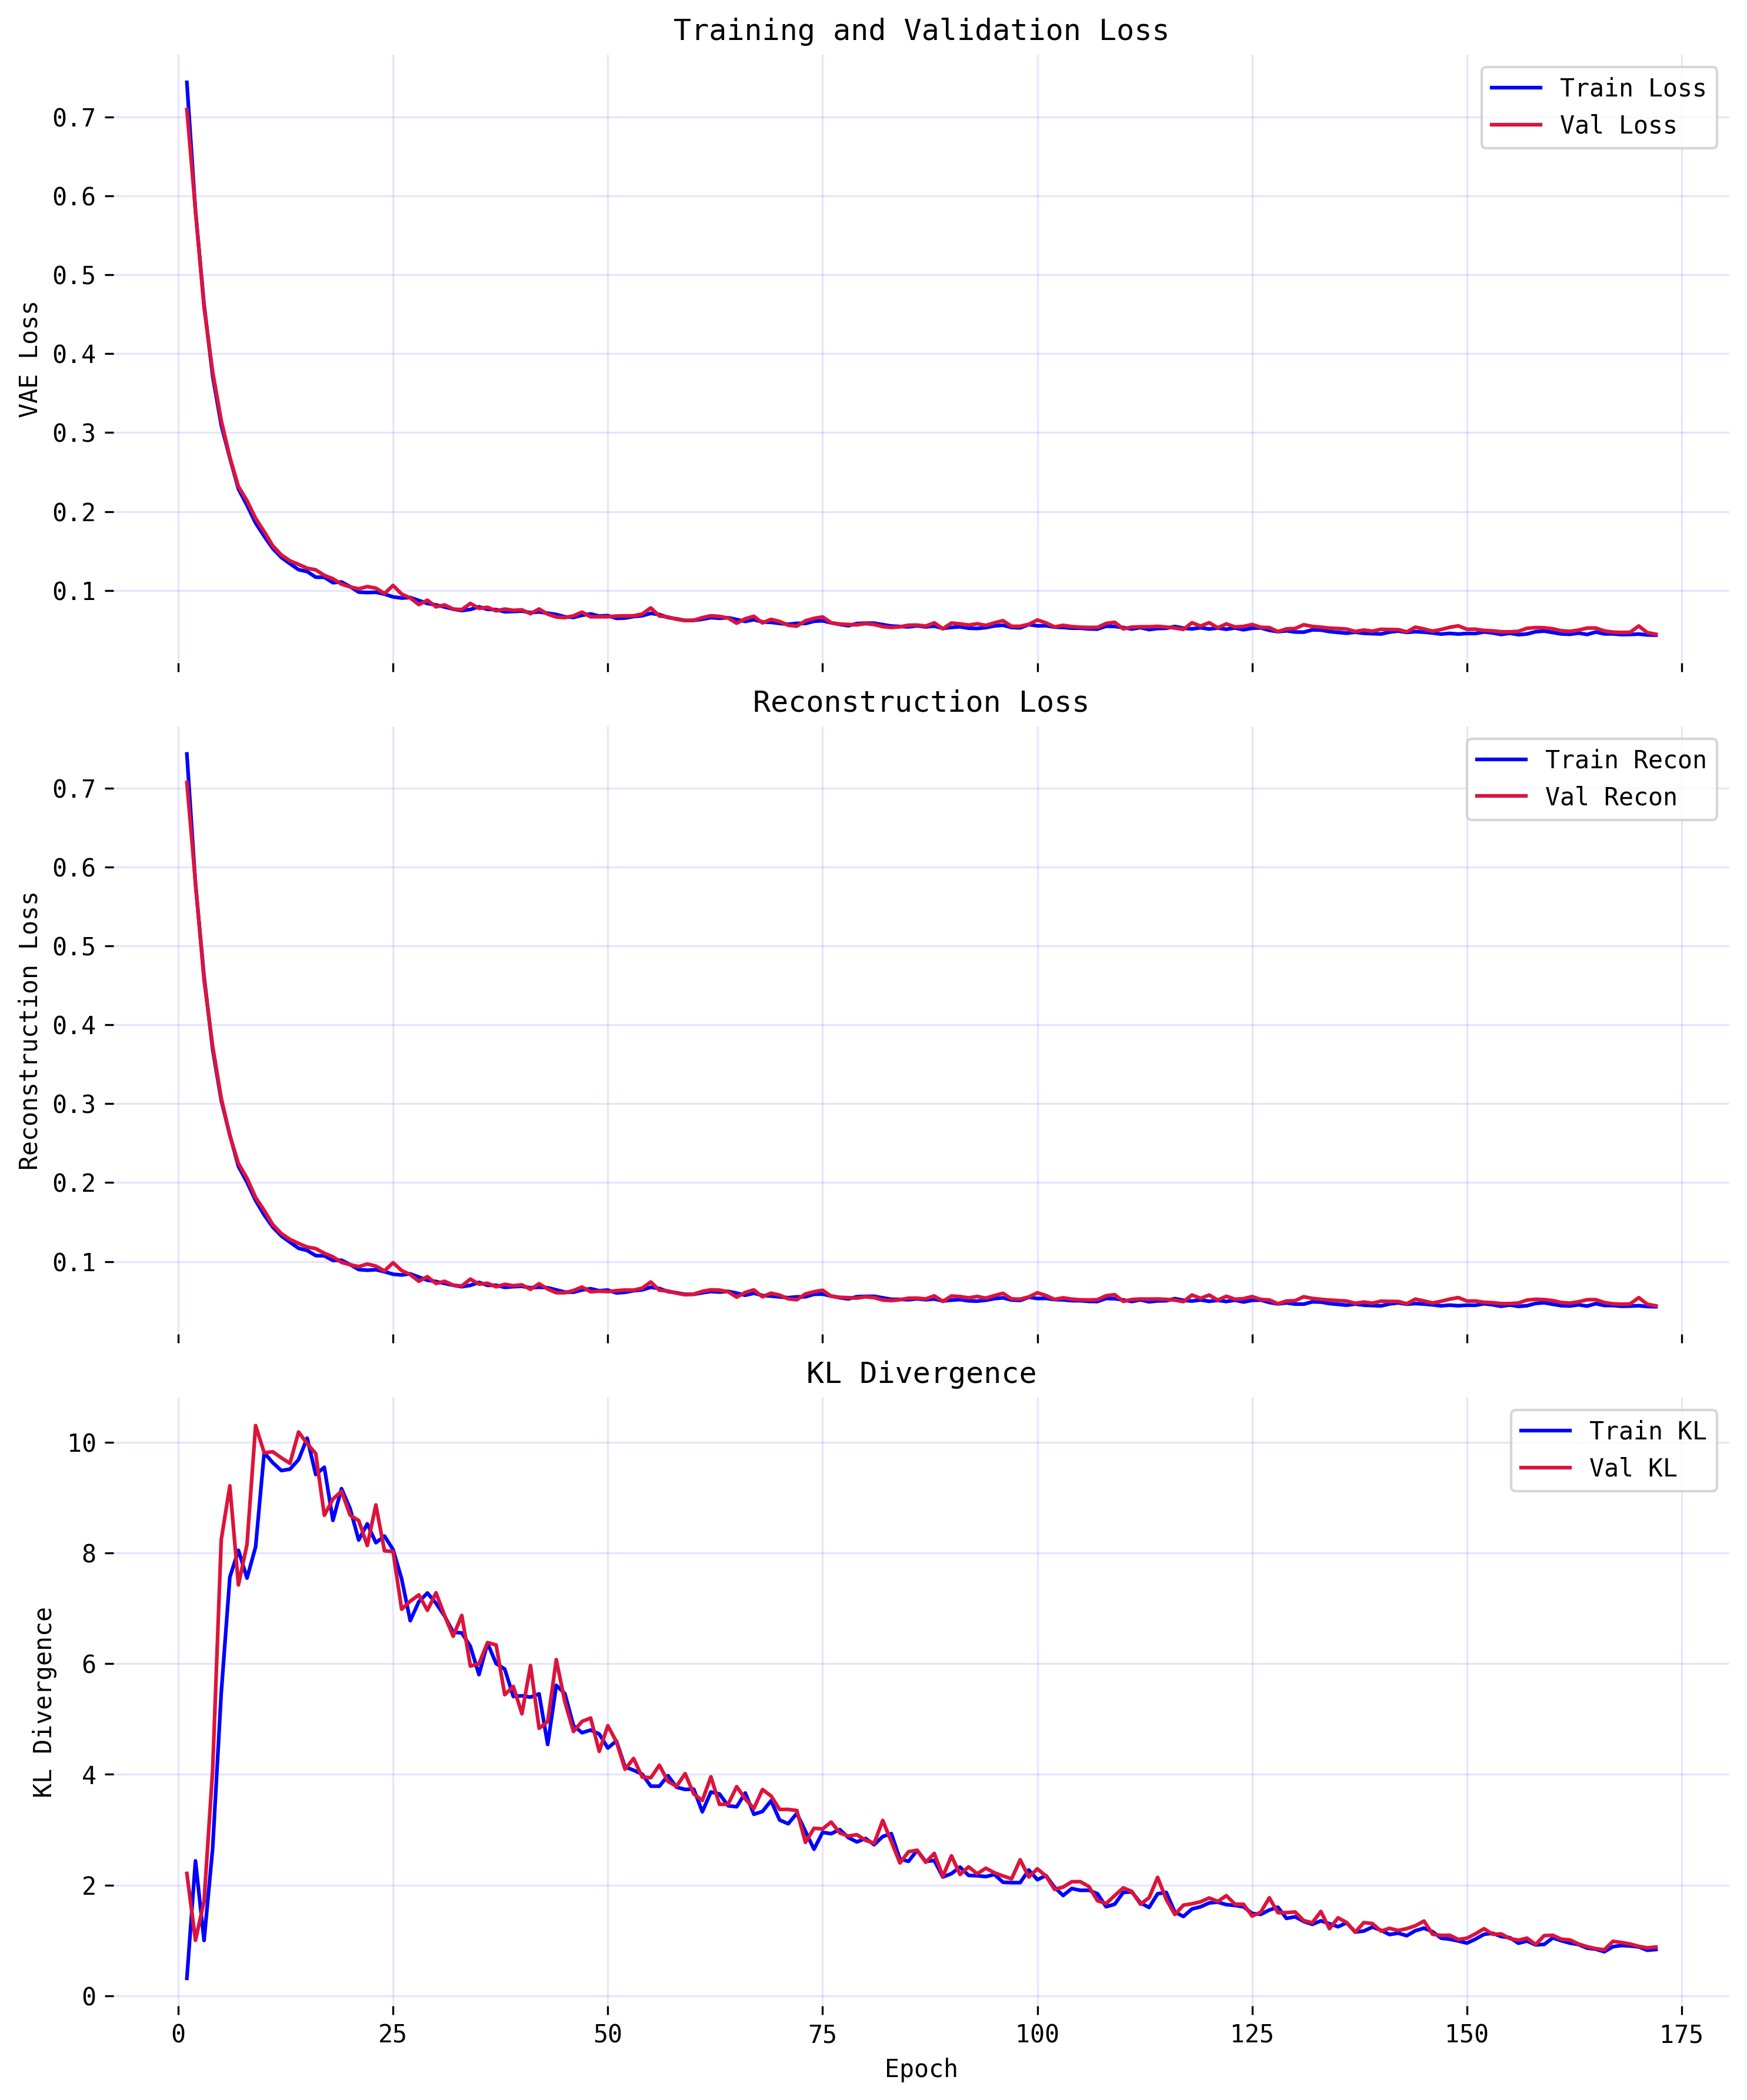

In [11]:
# Plot training and validation loss, reconstruction, and KL divergence
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

epochs = history["epoch"]

# Hide graph borders
for ax in axs:
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(True, color='b', alpha=0.1)


axs[0].plot(epochs, history["train_loss"], label="Train Loss", color = 'b')
axs[0].plot(epochs, history["val_loss"], label="Val Loss", color = 'crimson')
axs[0].set_ylabel("VAE Loss")
axs[0].legend()
axs[0].set_title("Training and Validation Loss")

axs[1].plot(epochs, history["train_recon"], label="Train Recon", color = 'b')
axs[1].plot(epochs, history["val_recon"], label="Val Recon", color = 'crimson')
axs[1].set_ylabel("Reconstruction Loss")
axs[1].legend()
axs[1].set_title("Reconstruction Loss")

axs[2].plot(epochs, history["train_kl"], label="Train KL", color = 'b')
axs[2].plot(epochs, history["val_kl"], label="Val KL", color = 'crimson')
axs[2].set_ylabel("KL Divergence")
axs[2].set_xlabel("Epoch")
axs[2].legend()
axs[2].set_title("KL Divergence")

plt.tight_layout()
plt.show()

## **3a. Reload Trained model**

In [ ]:
# # # Load a trained model
# checkpoint_file = "outputs/lstm_vae_general.pt"

# checkpoint = torch.load(checkpoint_file, map_location=device)
# model.load_state_dict(checkpoint["model_state_dict"])
# model.eval()
# print(f"Model loaded from {checkpoint_file}")

Model loaded from outputs/lstm_vae_general.pt


## **4. Reconstruction Test**

In [67]:
# Inspect a reconstruction against the ground-truth sequence
model.eval()  # evaluate mode ensures encoder/decoder behave deterministically
loader_for_eval = val_loader if val_loader is not None else train_loader
if loader_for_eval is None:
    raise ValueError("No data loader available for evaluation.")
dataset_for_eval = loader_for_eval.dataset

# Draw a random sample directly from the dataset for reproducibility and metadata access
sample_idx = random.randrange(len(dataset_for_eval))
sample_tensor, sample_length = dataset_for_eval[sample_idx]
sequence_batch = sample_tensor.unsqueeze(0).to(device)
length_batch = sample_length.unsqueeze(0).to(device)

with torch.no_grad():
    recon, _, _ = model(sequence_batch, length_batch)

# Gather metadata about the source trajectory
source_file = getattr(dataset_for_eval, "files", None)
source_name = source_file[sample_idx].name if source_file is not None else "unknown_source.csv"
print(f"Reconstructing sample index {sample_idx} from {source_name}")

# Compare the selected trajectory in original units
length = sample_length.item()
original = dataset_for_eval.denormalize(sample_tensor)[:length]
reconstructed = dataset_for_eval.denormalize(recon[0].cpu())[:length]
comparison = pd.DataFrame({"timestep": np.arange(length)})
for i, col in enumerate(seq_columns):
    comparison[f"orig_{col}"] = original[:, i].numpy()
    comparison[f"recon_{col}"] = reconstructed[:, i].numpy()
print(f"Per-coordinate MSE: {((original - reconstructed) ** 2).mean().item():.6f}")
comparison.head(10)


Reconstructing sample index 44 from impedance_record_61.csv
Per-coordinate MSE: 1.946861


,timestep,orig_X_mm,recon_X_mm,orig_Y_mm,recon_Y_mm,orig_Z_mm,recon_Z_mm,orig_alpha_rad,recon_alpha_rad,orig_beta_rad,recon_beta_rad,orig_gamma_rad,recon_gamma_rad
0,0,3.623672,12.014908,-605.986572,-616.747375,-9.729572,-9.816090,1.626897,1.674026,0.313923,0.308334,3.124211,3.082993
1,1,3.657135,7.925003,-605.795593,-614.239868,-9.687119,-9.945541,1.626952,1.659792,0.313808,0.315750,3.124203,3.089472
2,2,3.700314,6.190926,-605.640930,-611.306335,-9.613820,-10.014893,1.627020,1.649957,0.313825,0.315993,3.124199,3.096116
3,3,3.753822,5.212288,-605.641602,-609.813416,-9.486733,-9.966110,1.627094,1.646383,0.314299,0.316796,3.124216,3.099959
4,4,3.828182,4.848347,-605.861694,-609.404968,-9.275099,-9.857569,1.627185,1.647214,0.315319,0.318827,3.124251,3.102003
5,5,3.914494,4.625381,-606.385010,-609.504700,-8.940199,-9.550893,1.627285,1.649249,0.317211,0.321648,3.124337,3.103333
6,6,4.049862,4.572609,-607.465576,-610.066650,-8.367166,-8.997523,1.627418,1.651859,0.320834,0.325095,3.124501,3.104484
7,7,4.149914,4.674686,-608.516113,-610.872803,-7.869112,-8.431597,1.627502,1.654771,0.324222,0.328360,3.124664,3.105521
8,8,4.258060,4.850193,-609.854797,-611.909729,-7.247799,-7.795074,1.627585,1.657480,0.328423,0.331861,3.124874,3.106476
9,9,4.374172,5.078926,-611.331421,-613.139282,-6.584026,-7.111465,1.627668,1.659908,0.333012,0.335538,3.125101,3.107394


In [68]:
# Compare reconstruction against the original CSV on a per-joint basis
original_path = source_file[sample_idx] if source_file is not None else None
if original_path is not None and original_path.exists():
    csv_df = pd.read_csv(original_path)
    csv_tensor = torch.tensor(csv_df[seq_columns].values, dtype=torch.float32)[:length]
    # Align shapes (dataset may clip sequences to max_seq_len)
    min_len = min(csv_tensor.shape[0], reconstructed.shape[0])
    csv_tensor = csv_tensor[:min_len]
    recon_slice = reconstructed[:min_len]
    per_axis_mse = ((recon_slice - csv_tensor) ** 2).mean(dim=0)
    comparison_df = pd.DataFrame({
        'joint': seq_columns,
        'mse_vs_csv': per_axis_mse.numpy(),
    })
    print(f"Comparing reconstruction to original file: {original_path.name}")
    display(comparison_df)
else:
    print("Original file path unavailable; cannot compute per-axis MSE.")


Comparing reconstruction to original file: impedance_record_61.csv


,joint,mse_vs_csv
0,X_mm,0.944992
1,Y_mm,10.550331
2,Z_mm,0.184115
3,alpha_rad,0.001385
4,beta_rad,0.000019
5,gamma_rad,0.000325


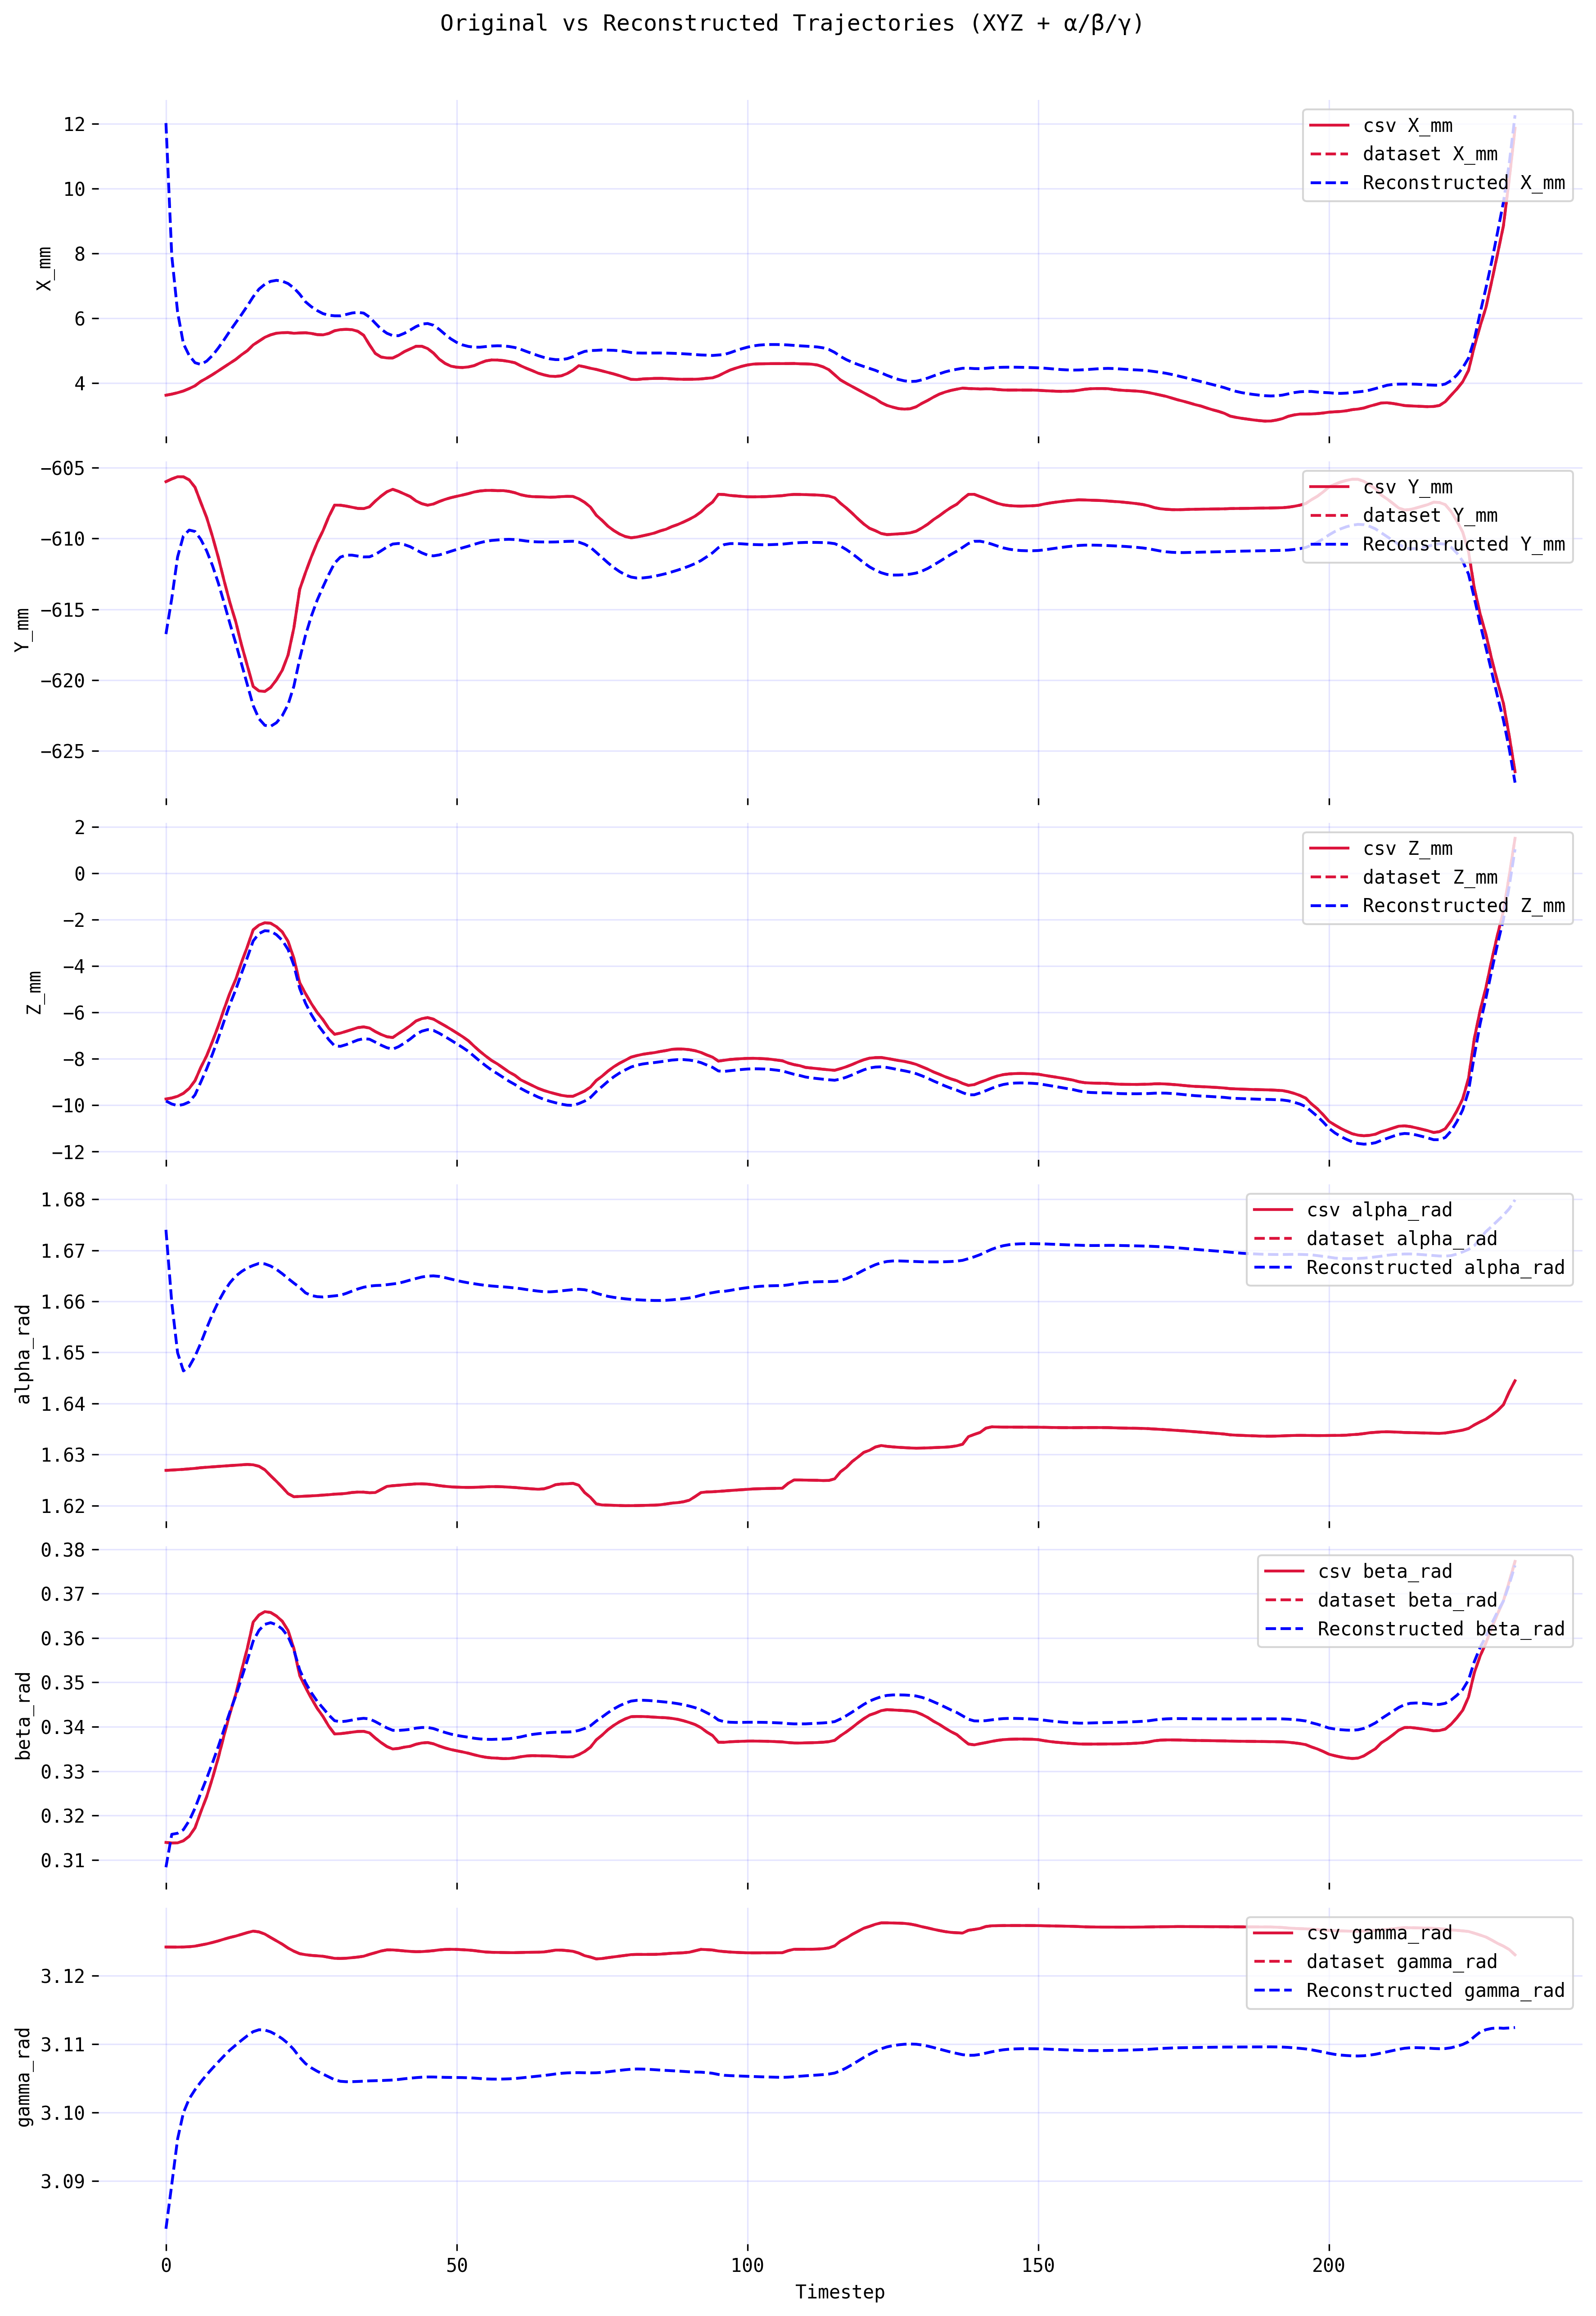

In [69]:
# Plot original vs reconstructed for each feature (XYZ + α/β/γ)
fig, axs = plt.subplots(len(seq_columns), 1, figsize=(12, 18), sharex=True)
timesteps = range(sample_length.item())

for i, col in enumerate(seq_columns):
    axs[i].plot(
        timesteps,
        csv_df.loc[:sample_length.item()-1, col].to_numpy(),
        label=f"csv {col}",
        color = 'crimson'
    )
    axs[i].plot(
        timesteps,
        original[:sample_length.item(), i].cpu().numpy(),
        label=f"dataset {col}",
        linestyle='--',
        color = 'crimson'
    )
    axs[i].plot(
        timesteps,
        reconstructed[:sample_length.item(), i].cpu().numpy(),
        label=f"Reconstructed {col}",
        linestyle='--',
        color = 'b'
    )
    axs[i].set_ylabel(col)
    axs[i].legend(loc='upper right')

    # spine removal + grid handling
    for s in axs[i].spines.values():
        s.set_visible(False)
    axs[i].grid(True, color='b', alpha=0.1)

axs[-1].set_xlabel("Timestep")
plt.suptitle("Original vs Reconstructed Trajectories (XYZ + α/β/γ)")
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

In [70]:
import pandas as pd
from pathlib import Path

# Save the reconstructed tensor as a CSV to the specified output path
output_dir = Path(r"C:\Users\chalm\Documents\Sem 3\Creative Robotics\3 Machine Learning XYZ\outputs")
output_file = output_dir / "recon.csv"
pd.DataFrame(reconstructed.cpu().numpy(), columns=seq_columns).to_csv(output_file, index=False)
print(f"Reconstruction saved to {output_file}")

Reconstruction saved to C:\Users\chalm\Documents\Sem 3\Creative Robotics\3 Machine Learning XYZ\outputs\recon.csv


## **5. Visualize Latent Space: t-SNE**

In [12]:
#zorder for annotation and grid are swapped to make images "appear" to have no background

def collect_latent_embeddings(include_generated=False):
    model.eval()
    splits = [('train', train_dataset), ('val', val_dataset)]
    embeddings, labels, sample_ids = [], [], []

    with torch.no_grad():
        for split_name, dataset in splits:
            if not dataset:
                continue
            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
            dataset_files = getattr(dataset, 'files', None)
            file_stems = [Path(f).stem for f in dataset_files] if dataset_files else None
            offset = 0
            for sequences, lengths in loader:
                sequences, lengths = sequences.to(device), lengths.to(device)
                mu, _ = model.encode(sequences, lengths)
                emb = mu.detach().cpu()
                n = emb.shape[0]
                embeddings.append(emb)
                labels.extend([split_name] * n)
                if file_stems:
                    sample_ids.extend(file_stems[offset:offset + n])
                    offset += n
                else:
                    sample_ids.extend([''] * n)

    if not embeddings:
        raise ValueError('No latent embeddings available for t-SNE plot. Ensure datasets and model weights are loaded.')

    base_latent = torch.cat(embeddings, dim=0).numpy().astype(np.float32)
    if base_latent.shape[0] <= 2:
        raise ValueError('Need more than two samples to compute t-SNE.')

    base_labels = np.array(labels)
    base_sample_ids = np.array(sample_ids)
    data = {
        'base_latent': base_latent,
        'base_labels': base_labels,
        'base_sample_ids': base_sample_ids,
        '_generated_ids_tuple': (),
    }

    if include_generated and 'generated_metadata' in globals():
        latent = np.asarray(generated_metadata.get('latent', []), dtype=np.float32)
        if latent.size:
            stems = [Path(p).stem for p in generated_metadata.get('paths', [])]
            if len(stems) != latent.shape[0]:
                stems = [f'generated_{i}' for i in range(latent.shape[0])]
            data['generated_latent'] = latent
            data['generated_labels'] = np.full(latent.shape[0], 'generated')
            data['generated_sample_ids'] = np.array(stems)
            data['_generated_ids_tuple'] = tuple(stems)
    data['_include_generated'] = bool(include_generated)
    return data

tsne_state = globals().get('tsne_state', {
    'embedding': None,
    'base_latent': None,
    'base_coords': None,
    'base_labels': None,
    'base_sample_ids': None,
    'perplexity': None,
    'random_state': None,
})
globals()['tsne_state'] = tsne_state

def plot_tsne_img(embeddings=None, perplexity=30, max_iter=1000, random_state=42, plot_img=False,
                     image_dir=Path('data_img'), image_zoom=0.015,
                     include_generated=False, force_refit=False, show_legend=True):

    include_generated = include_generated and embeddings.get('_include_generated', False)

    base_latent = np.asarray(embeddings['base_latent'], dtype=np.float32)
    base_labels = np.array(embeddings['base_labels'])
    base_sample_ids = np.array(embeddings['base_sample_ids'])

    if base_latent.shape[0] <= 2:
        raise ValueError('Need more than two samples to compute t-SNE.')

    effective_perplexity = min(perplexity, max(5, base_latent.shape[0] - 1))
    n_iter = max(250, max_iter)

    needs_refit = (
        force_refit
        or tsne_state['embedding'] is None
        or tsne_state['perplexity'] != effective_perplexity
        or tsne_state['random_state'] != random_state
        or tsne_state['base_latent'] is None
        or tsne_state['base_latent'].shape != base_latent.shape
        or not np.allclose(tsne_state['base_latent'], base_latent)
    )

    if needs_refit:
        tsne = TSNE(
            n_components=2,
            perplexity=effective_perplexity,
            metric='euclidean',
            random_state=random_state,
            initialization='pca',
            n_iter=n_iter,
        )
        embedding = tsne.fit(base_latent)
        base_coords = np.asarray(embedding)
        tsne_state.update({
            'embedding': embedding,
            'base_latent': base_latent.copy(),
            'base_coords': base_coords.copy(),
            'base_labels': base_labels,
            'base_sample_ids': base_sample_ids,
            'perplexity': effective_perplexity,
            'random_state': random_state,
            'n_iter': n_iter,
        })
    else:
        embedding = tsne_state['embedding']
        base_coords = tsne_state['base_coords']
        base_labels = tsne_state['base_labels']
        base_sample_ids = tsne_state['base_sample_ids']

    plot_coords = [base_coords]
    plot_labels = [base_labels]
    plot_ids = [base_sample_ids]

    generated_latent = None
    generated_labels = None
    generated_sample_ids = None
    if include_generated:
        generated_latent = embeddings.get('generated_latent')
        generated_labels = embeddings.get('generated_labels')
        generated_sample_ids = embeddings.get('generated_sample_ids')
        if generated_latent is not None and generated_latent.size:
            new_coords = np.asarray(embedding.transform(generated_latent, perplexity=effective_perplexity))
            plot_coords.append(new_coords)
            plot_labels.append(generated_labels)
            plot_ids.append(generated_sample_ids)

    coords = np.vstack(plot_coords)
    labels = np.concatenate(plot_labels)
    sample_ids = np.concatenate(plot_ids)

    image_dir = Path(image_dir)
    color_map = {'train': '#1f77b4', 'val': '#ff7f0e', 'generated': '#d62728'}

    fig, ax = plt.subplots(figsize=(12, 12))
    ax.scatter(coords[:, 0], coords[:, 1], marker='x', s=5, linewidths=0.5, alpha=0)  # allocate limits

    def resolve_image_path(sample_id: str):
        if not sample_id:
            return None
        candidates = []
        digits = re.findall(r'\d+', sample_id)
        for d in reversed(digits):
            try:
                num = int(d)
            except ValueError:
                continue
            candidates.extend([f'Data-{num}', f'Data-{num:02d}', f'Data-{num:03d}', f'Data-{num:04d}'])
        candidates.extend([sample_id, sample_id.replace(' ', '_')])
        seen = set()
        for base_name in candidates:
            if base_name in seen:
                continue
            seen.add(base_name)
            p = image_dir / f'{base_name}.png'
            if p.exists():
                return p
        matches = sorted(image_dir.glob(f'*{sample_id}*.png'))
        return matches[0] if matches else None

    legend_handles, legend_labels = [], []
    for split_name in sorted(set(labels)):
        mask = (labels == split_name)
        split_coords = coords[mask]
        split_ids = sample_ids[mask]
        color = color_map.get(split_name, '#555555')
        count = int(mask.sum())

        if split_name == 'generated':
            for idx_local, ((x_coord, y_coord), sid) in enumerate(zip(split_coords, split_ids)):
                digits = re.findall(r"\d+", sid) if isinstance(sid, str) else []
                label_text = digits[-1] if digits else str(idx_local)
                ax.text(
                    x_coord,
                    y_coord,
                    label_text,
                    fontsize=9,
                    fontweight='bold',
                    color=color,
                    ha='center',
                    va='center',
                )
            legend_handles.append(Line2D([0], [0], marker='s', linestyle='', markersize=8,
                                         markerfacecolor='none', markeredgecolor=color, color=color))
            legend_labels.append(f"{split_name} ({count})")
            continue

        if not plot_img:
            handle = ax.scatter(split_coords[:, 0], split_coords[:, 1],
                                marker='x', s=35, linewidths=1.1, alpha=0.8, color=color)
            legend_handles.append(handle)
            legend_labels.append(f"{split_name} ({count})")
        else:
            for (x_coord, y_coord), sid in zip(split_coords, split_ids):
                img_path = resolve_image_path(sid)
                if img_path is None:
                    ax.scatter(x_coord, y_coord, marker='x', s=35, linewidths=1.1, alpha=0.8, color=color)
                    continue
                image = plt.imread(img_path)
                ann = AnnotationBbox(OffsetImage(image, zoom=image_zoom),
                                     (x_coord, y_coord), frameon=False, zorder=1)
                ax.add_artist(ann)
            legend_handles.append(Line2D([0], [0], marker='x', linestyle='', markersize=8, color=color))
            legend_labels.append(f"{split_name} ({count})")

    if show_legend and legend_handles:
        ax.legend(legend_handles, legend_labels, loc='best', frameon=False)

    ax.set_title('t-SNE projection of latent space')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')

    for s in ax.spines.values():
        s.set_visible(False)

    ax.grid(True, color='b', linewidth=0.6, alpha=0.08, zorder=10)

    plt.show()


In [13]:
tsne_embeddings = collect_latent_embeddings()

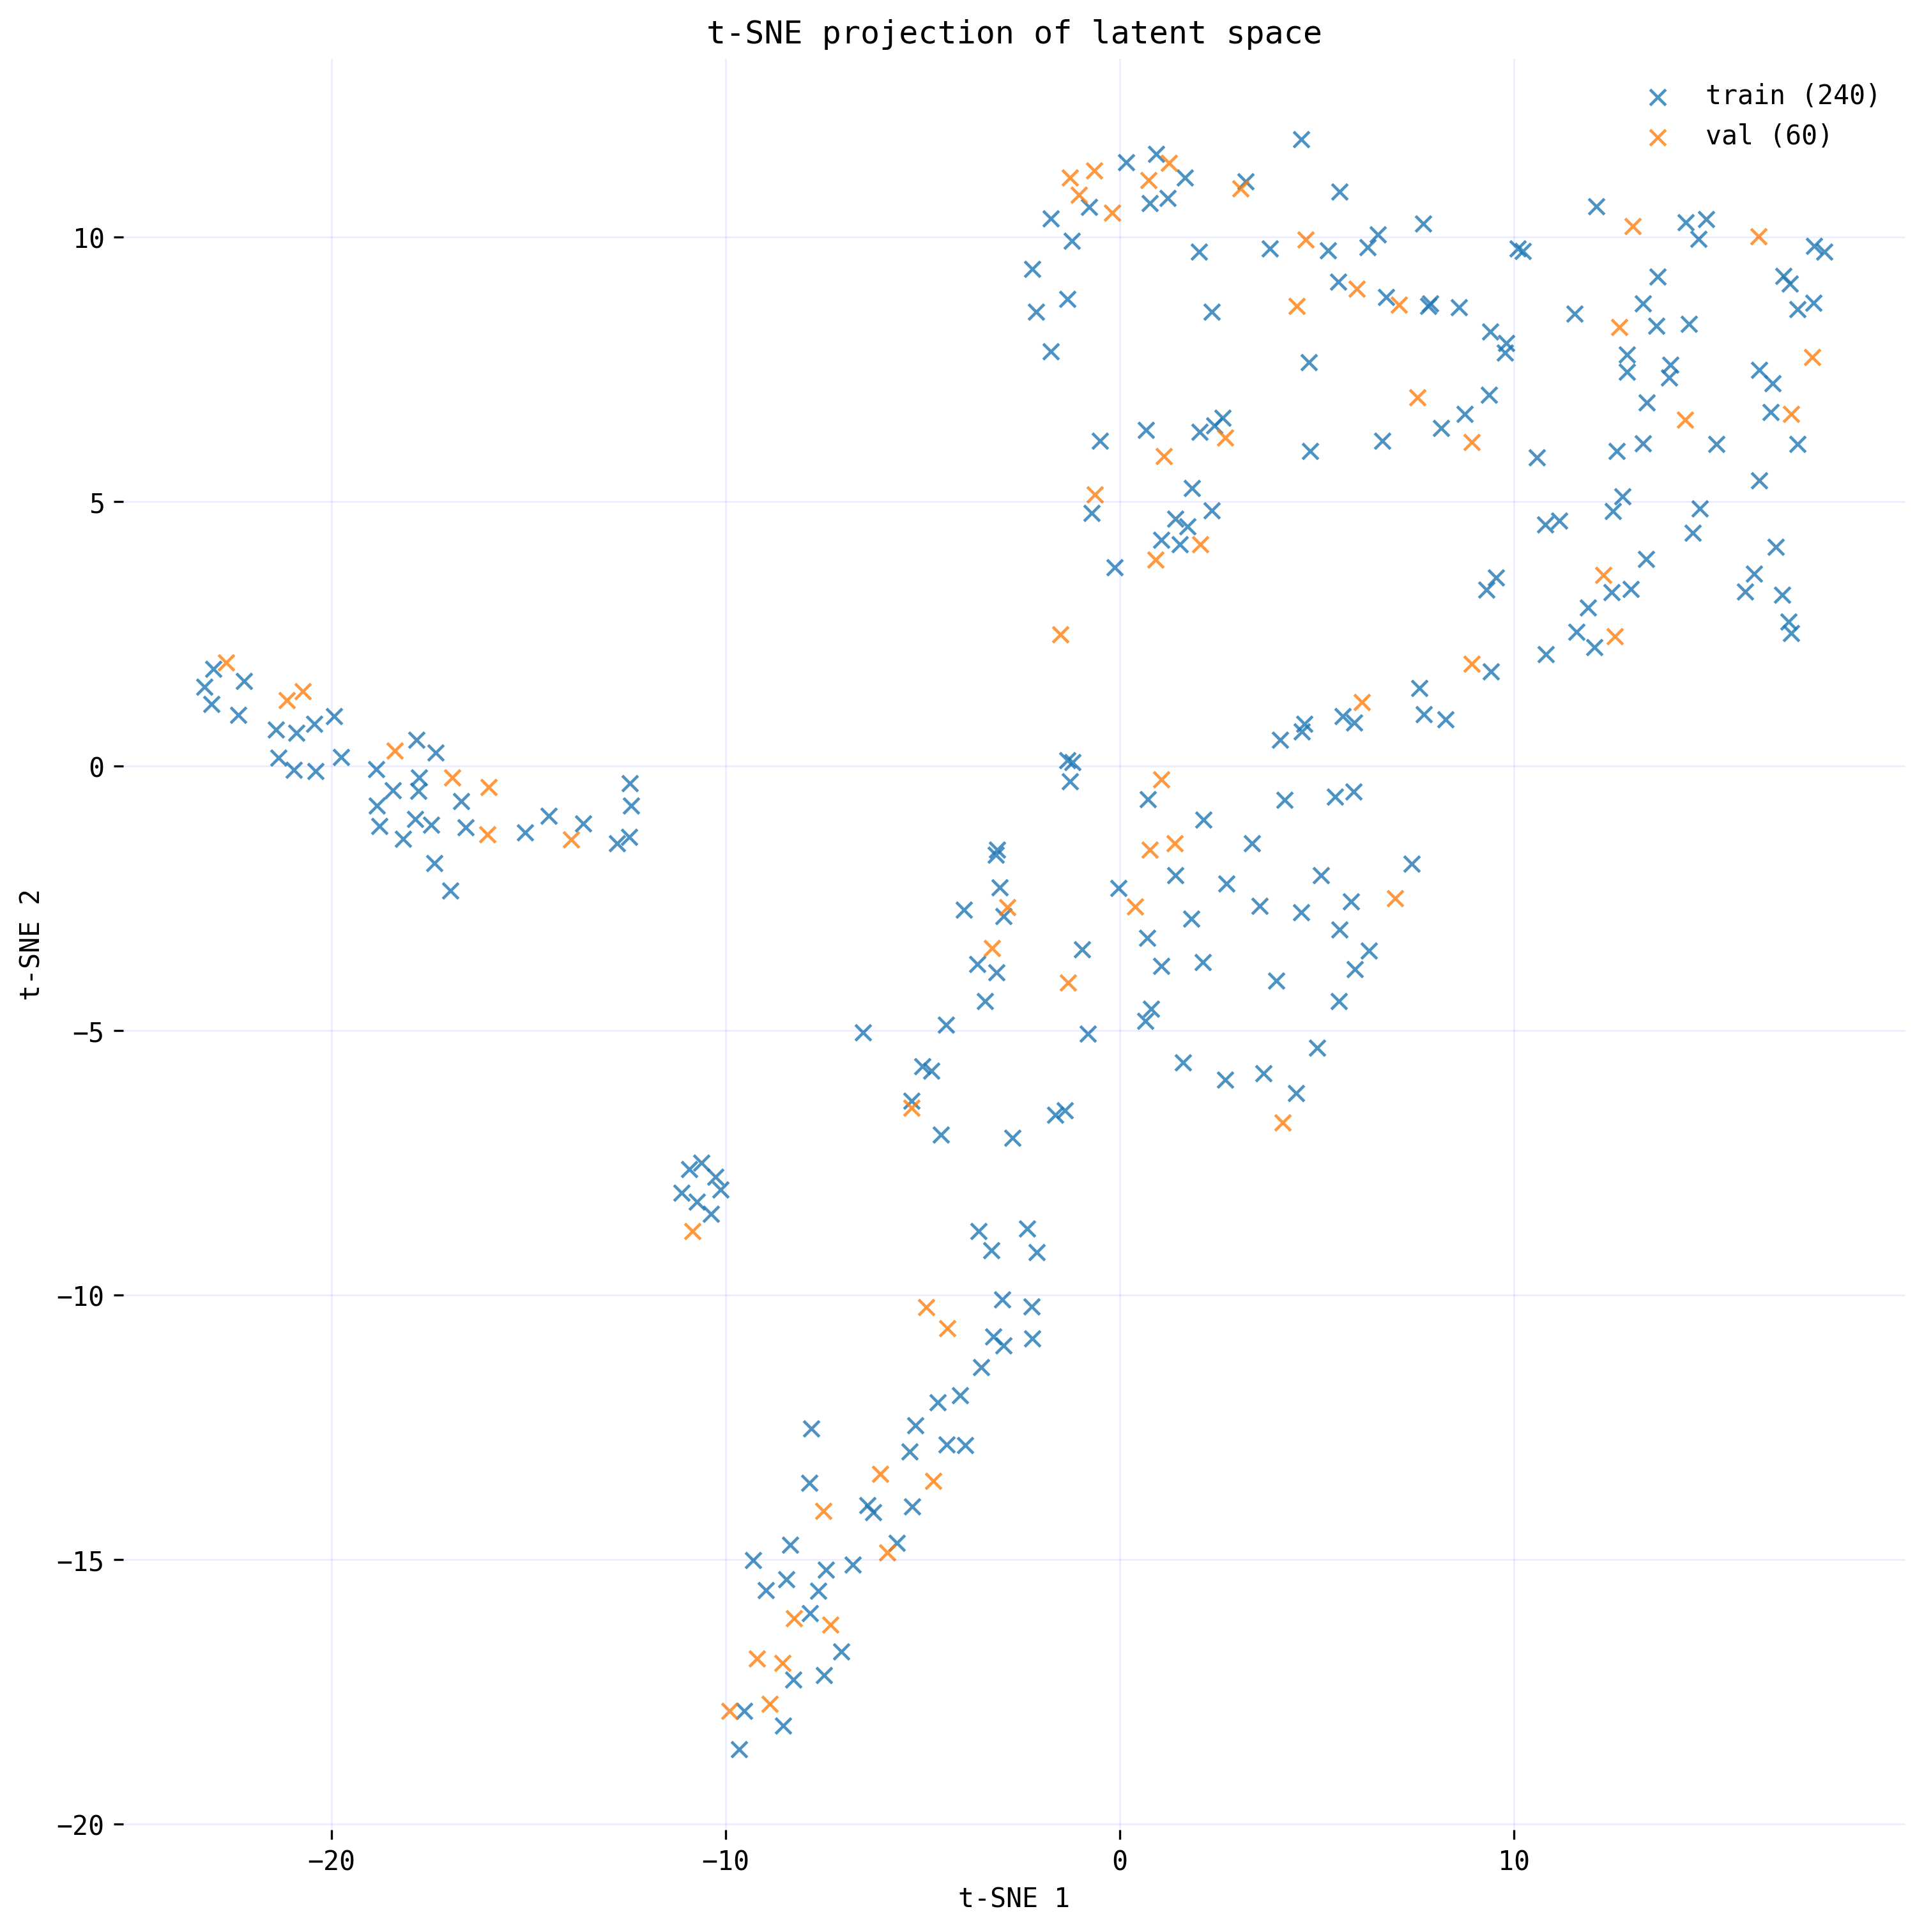

In [14]:
plot_tsne_img(embeddings = tsne_embeddings, plot_img=False)

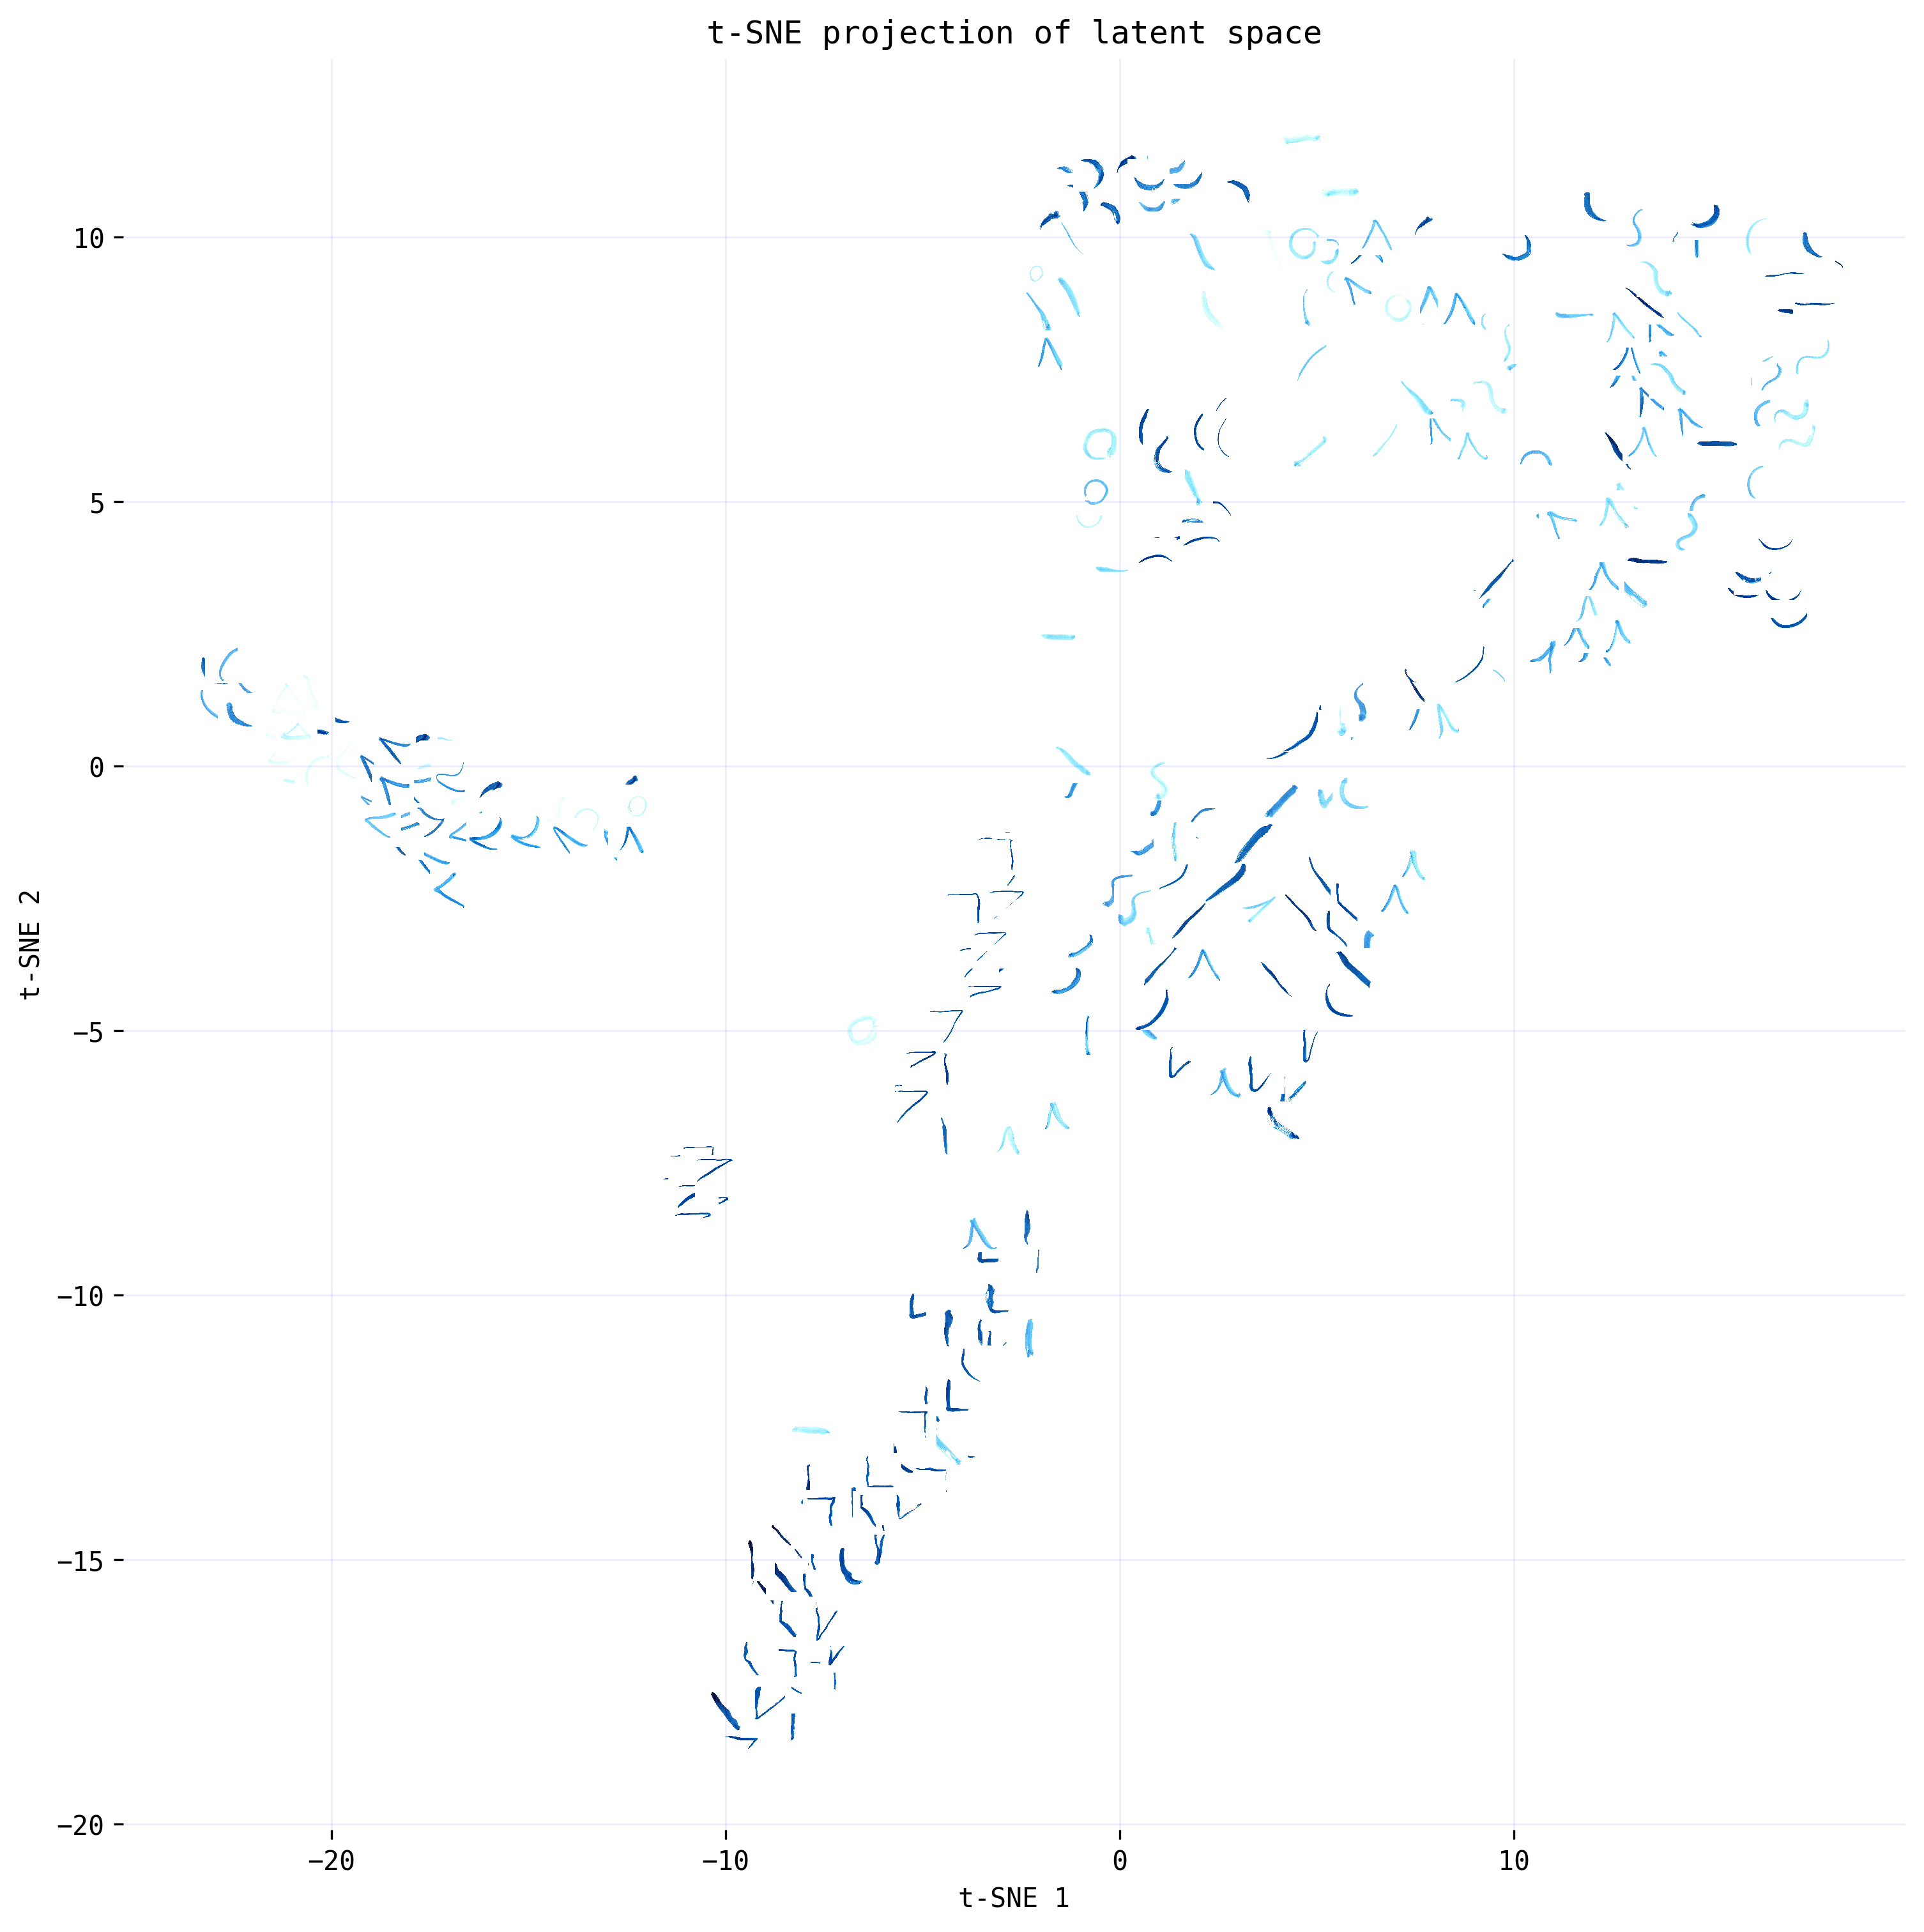

In [15]:
plot_tsne_img(embeddings = tsne_embeddings, plot_img=True, show_legend=False)

## **6. Generate New Trajectories**

In [24]:
# Generate new latent samples and save them to CSV files
model.eval()
num_new_samples = 10
sample_length = 150


if len(train_dataset) == 0:
    raise ValueError("Training dataset is empty; cannot generate samples.")
#target_lengths = random.choices(train_dataset.lengths, k=num_new_samples)
target_lengths = [sample_length for _ in range(num_new_samples)]
print(f"Generating {num_new_samples} samples with target lengths: {target_lengths}")

#override additional 5 timesteps to compensate early timestep error (will be clipped later)
target_lengths = [sample_length + 5 for _ in range(num_new_samples)]
lengths_tensor = torch.tensor(target_lengths, device=device, dtype=torch.long)

with torch.no_grad():
    generated_latent_samples = torch.randn(num_new_samples, latent_dim, device=device)
    decoded_sequences = model.generate(generated_latent_samples, lengths_tensor)
    decoded_sequences = train_dataset.denormalize(decoded_sequences.cpu())
generated_latent_samples_cpu = generated_latent_samples.detach().cpu()

outputs_dir = Path("outputs")
outputs_dir.mkdir(parents=True, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
generated_filepaths = []
for idx, length in enumerate(target_lengths):
    seq = decoded_sequences[idx, 5:length].numpy()
    df_out = pd.DataFrame(seq, columns=seq_columns)
    output_path = outputs_dir / f"4LSTMVAE_VELAWARE_sample_{timestamp}_{idx}.csv"
    df_out.to_csv(output_path, index=False)
    generated_filepaths.append(str(output_path))
    print(f"Generated sample {idx} saved to {output_path}")

generated_metadata = {
    "paths": generated_filepaths,
    "latent": generated_latent_samples_cpu.numpy(),
    "lengths": target_lengths,
}

Generating 10 samples with target lengths: [150, 150, 150, 150, 150, 150, 150, 150, 150, 150]
Generated sample 0 saved to outputs\4LSTMVAE_VELAWARE_sample_20251028_142514_0.csv
Generated sample 1 saved to outputs\4LSTMVAE_VELAWARE_sample_20251028_142514_1.csv
Generated sample 2 saved to outputs\4LSTMVAE_VELAWARE_sample_20251028_142514_2.csv
Generated sample 3 saved to outputs\4LSTMVAE_VELAWARE_sample_20251028_142514_3.csv
Generated sample 4 saved to outputs\4LSTMVAE_VELAWARE_sample_20251028_142514_4.csv
Generated sample 5 saved to outputs\4LSTMVAE_VELAWARE_sample_20251028_142514_5.csv
Generated sample 6 saved to outputs\4LSTMVAE_VELAWARE_sample_20251028_142514_6.csv
Generated sample 7 saved to outputs\4LSTMVAE_VELAWARE_sample_20251028_142514_7.csv
Generated sample 8 saved to outputs\4LSTMVAE_VELAWARE_sample_20251028_142514_8.csv
Generated sample 9 saved to outputs\4LSTMVAE_VELAWARE_sample_20251028_142514_9.csv


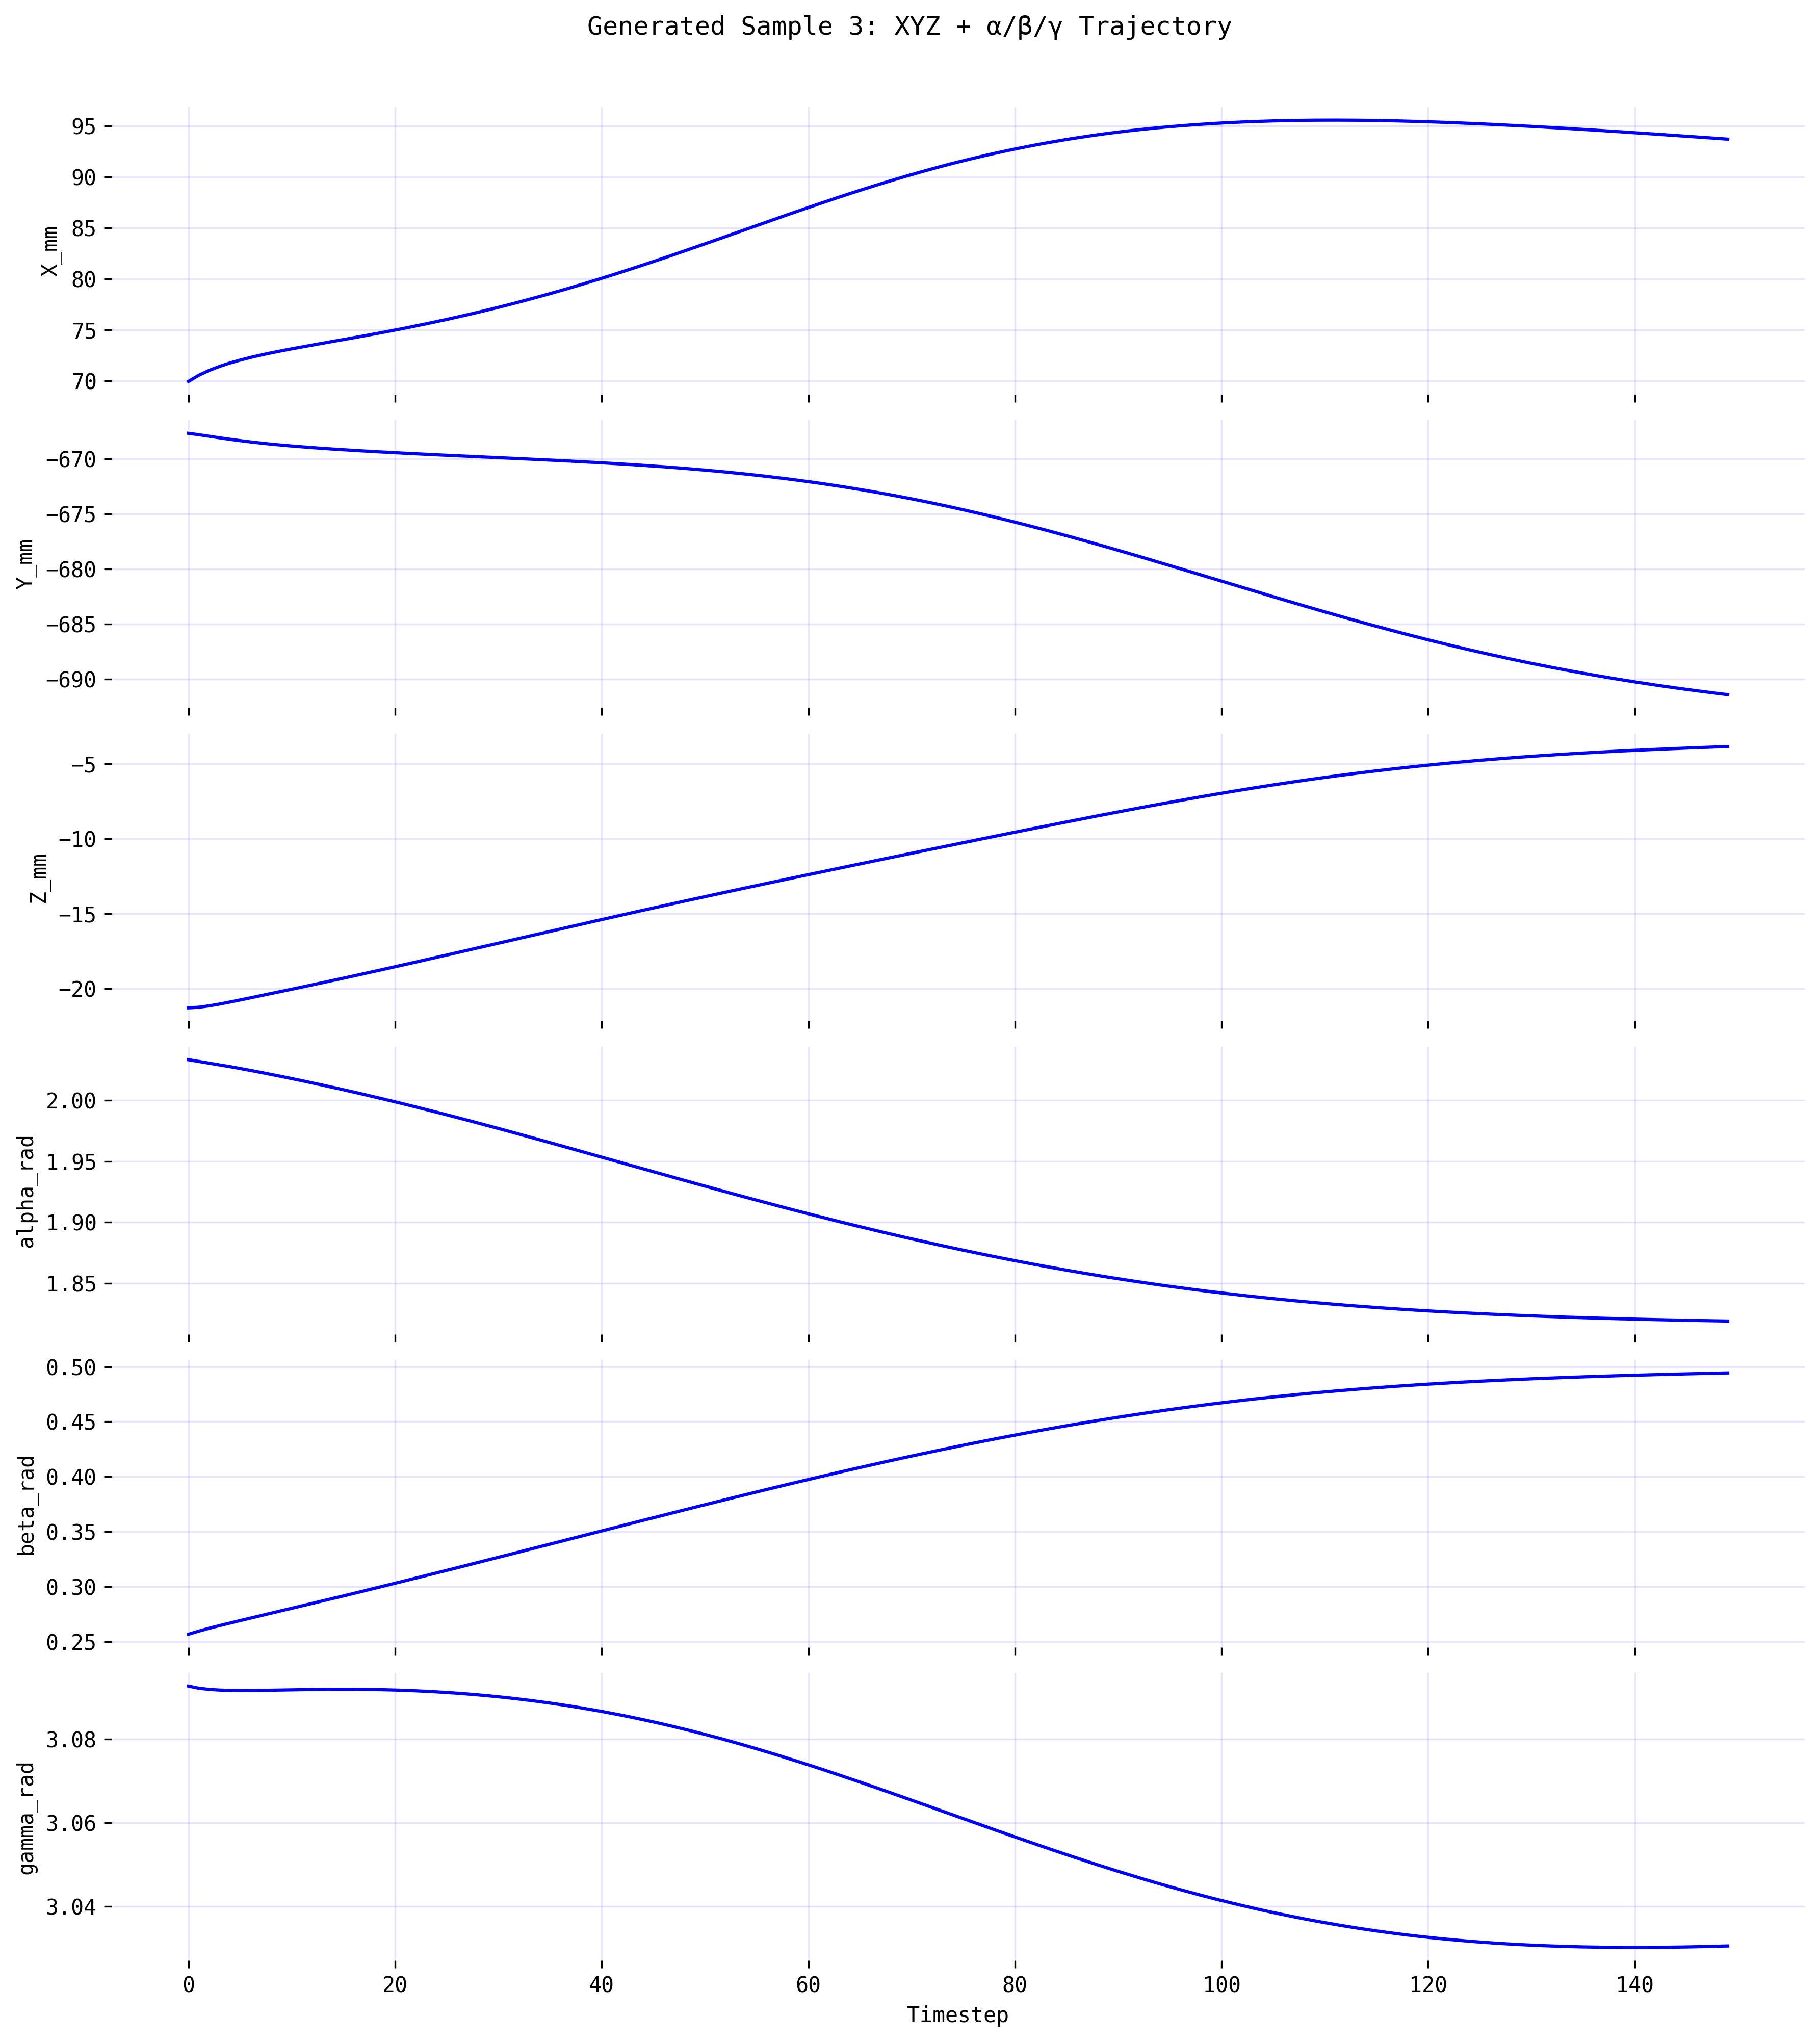

In [25]:
# Choose a sample index n
n = 3  # Change this to select a different sample

# Get the generated sequence for sample n
seq = pd.read_csv(generated_metadata["paths"][n]).to_numpy()

# Plot each feature over time
fig, axs = plt.subplots(len(seq_columns), 1, figsize=(12, 14), sharex=True)
timesteps = range(seq.shape[0])

for i, col in enumerate(seq_columns):
    axs[i].plot(timesteps, seq[:, i], label=col, color='b')
    axs[i].set_ylabel(col)
    # spine removal + grid handling
    for s in axs[i].spines.values():
        s.set_visible(False)
    axs[i].grid(True, color='b', alpha=0.1)

axs[-1].set_xlabel("Timestep")

plt.suptitle(f"Generated Sample {n}: XYZ + α/β/γ Trajectory")
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

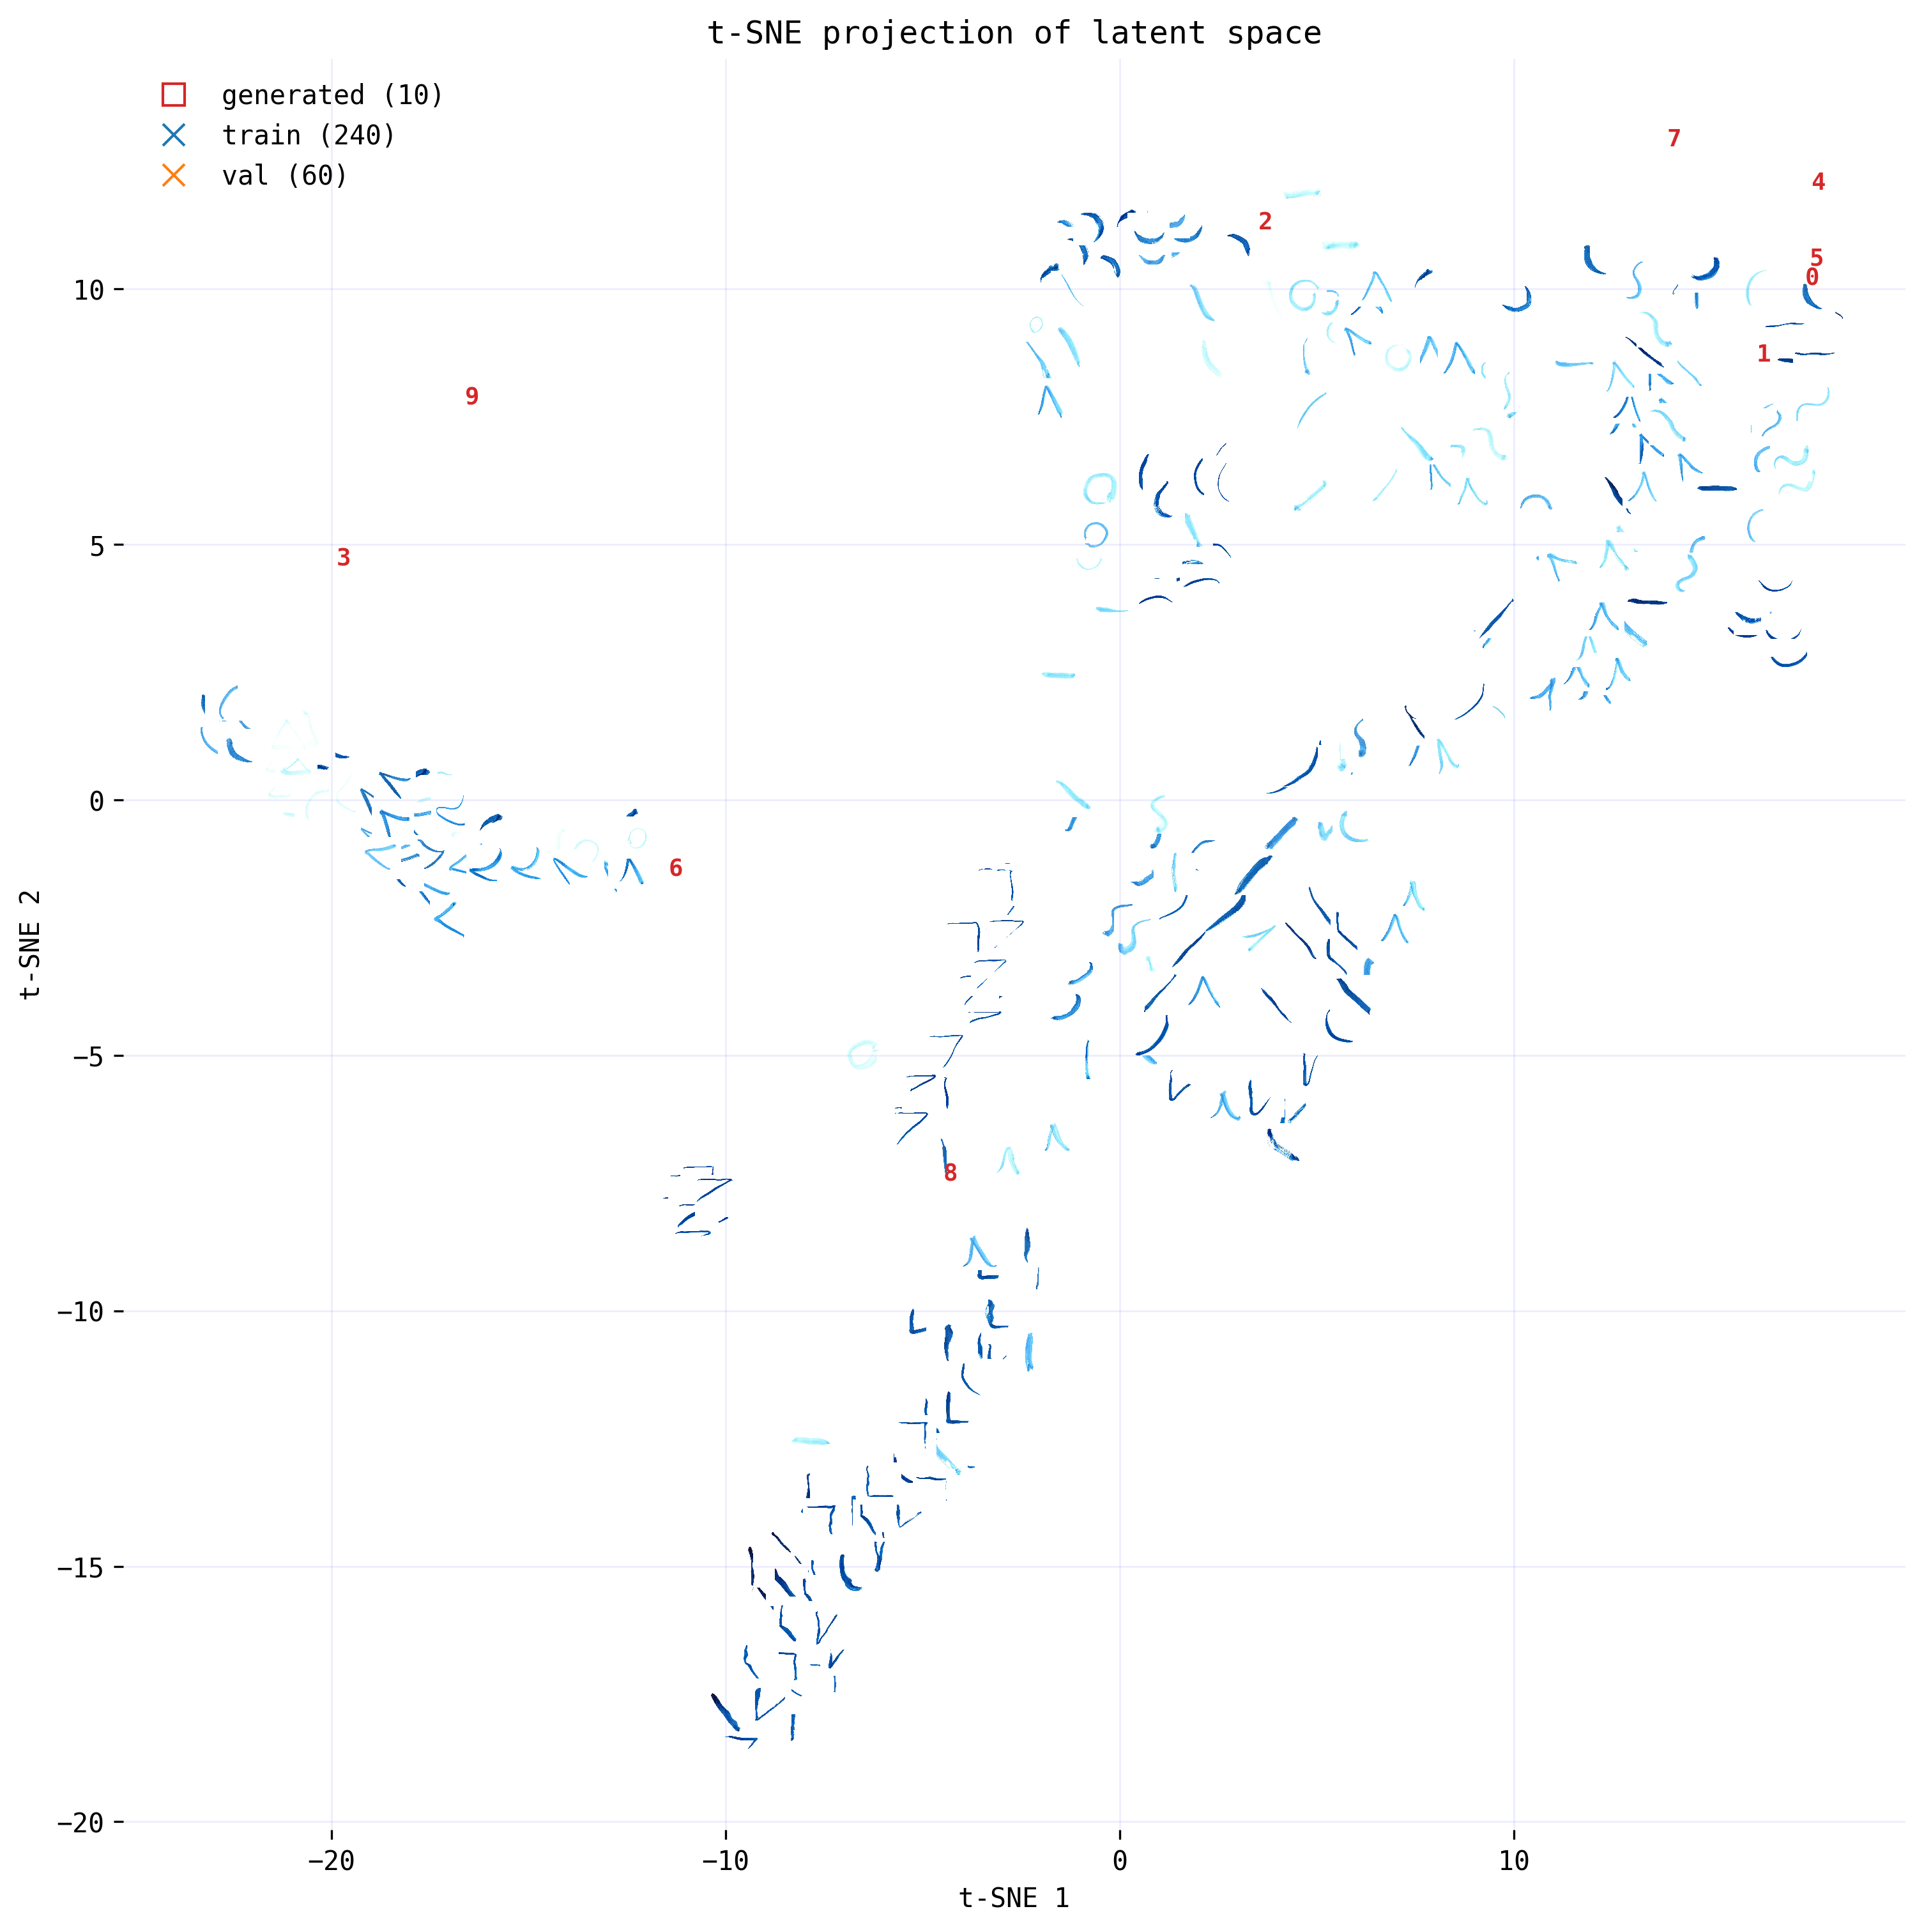

In [26]:
# --- Config for image plotting ---
plot_img = True                     # set False to fall back to dots
image_dir = Path('data_img')        # folder containing *.png images
image_zoom = 0.015                  # adjust for sizing
include_generated = 'generated_metadata' in globals()
force_refresh_embeddings = False    # set True after generating new samples or changing datasets

current_generated_ids = ()
if include_generated:
    current_generated_ids = tuple(Path(p).stem for p in generated_metadata.get('paths', []))

needs_new_embeddings = (
    'tsne_embeddings' not in globals()
    or tsne_embeddings is None
    or force_refresh_embeddings
    or bool(tsne_embeddings.get('_include_generated', False)) != include_generated
    or (include_generated and tsne_embeddings.get('_generated_ids_tuple') != current_generated_ids)
)

if needs_new_embeddings:
    tsne_embeddings = collect_latent_embeddings(include_generated=include_generated)

plot_tsne_img(
    embeddings=tsne_embeddings,
    plot_img=plot_img,
    image_dir=image_dir,
    image_zoom=image_zoom,
    include_generated=include_generated,
)
